# Project 3 analyzing the best model

## In this notebook we will work with only the best model.

For project 3, your goal is two-fold:
1. Using Reddit's API, you'll collect posts from two subreddits of your choosing.
2. You'll then use NLP to train a classifier on which subreddit a given post came from. This is a binary classification problem.

**In this Jupyter Notebook, we will focus on the best model from the *second* part of the project.**

In [4]:
import pandas as pd
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

## Read the data:
First we need to read the dataframe we created in the part 1 of the project

In [5]:
data = pd.read_csv('../data (gathered)/project3.csv', encoding = 'ISO-8859-1')

In [6]:
# We take a look at the 'head' and 'tail' of the dataframe to see what is made of.
data.head()

,Unnamed: 0,titles,text,subreddit type
0,5097,"Hey it's 9/11, so what kinds of sales and door...",NaN,0
1,5310,I think the ghost haunting my house is into me...,NaN,0
2,957,I have feelings for someone I met online. I do...,"I haven't had feelings for anyone in years, le...",1
3,306,Is this kids hair color black or brown?,"Tell me reddit, black or brown?\n\nhttps://med...",1
4,5088,Im gonna keep this post simple,"Alright guys, how would one go about getting f...",0


In [7]:
data.tail()

,Unnamed: 0,titles,text,subreddit type
1944,529,Does my Username sound like follow the christi...,NaN,1
1945,5950,Swiped right on my cousin who is married.,"Was drunk and she's hot, think I have a chance?",0
1946,297,Any advice on tickling myself in my sleep ?,Iâve been told and do have videos of my tick...,1
1947,726,Wife (34f) whose husband (35m) told her she is...,My husband and I have been married for 11 year...,1
1948,692,Is it weird that I dry and not wash my clothes?,"So I usually do all my laundry every weekend, ...",1


In [8]:
# We also check (again) that we have sufficient data from both of the subreddits.
data['subreddit type'].value_counts()

0    991
1    958
Name: subreddit type, dtype: int64

**Comment:** we can see that we do not have unbalanced data, which is a good thing.

In [9]:
# Looking at the data shape we notice that we have one more column than we had in part 1 (the previous Jupyter notebook)
data.shape

(1949, 4)

### Dropping missing values
We look at the missing values we have and decide whether to drop them or not.

In [10]:
data.isnull().sum()

Unnamed: 0          0
titles              0
text              715
subreddit type      0
dtype: int64

**Comment:** We notice that there are 715 rows that are missing the text.
Dropping them would mean loosing almost half of our data. Moreover, the missing text comes mostly from the second subreddit (shittyadvice). Dropping all the text values would make our model unbalanced. 
Since we are focusing on the titles for our X values, we decide to not drop the rows.

In [11]:
# First, we created a model without the rows that had missing values, but this model was worse than the others.
#data.dropna(inplace=True)

### Dropping unnecessary columns:
We proceed to drop the unnecessary columns (e.g. 'Unnamed: 0')

In [12]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [13]:
data.head()

,titles,text,subreddit type
0,"Hey it's 9/11, so what kinds of sales and door...",NaN,0
1,I think the ghost haunting my house is into me...,NaN,0
2,I have feelings for someone I met online. I do...,"I haven't had feelings for anyone in years, le...",1
3,Is this kids hair color black or brown?,"Tell me reddit, black or brown?\n\nhttps://med...",1
4,Im gonna keep this post simple,"Alright guys, how would one go about getting f...",0


In [14]:
# We check to see whether the shape is the same as in part 1 of the project (1949,3)
data.shape

(1949, 3)

# Creating a new column with ALL the text (titles + text)

In [15]:
data['all_text']= data['titles'] + ' ' + data['text'].map(str)

In [16]:
data

,titles,text,subreddit type,all_text
0,"Hey it's 9/11, so what kinds of sales and door...",NaN,0,"Hey it's 9/11, so what kinds of sales and door..."
1,I think the ghost haunting my house is into me...,NaN,0,I think the ghost haunting my house is into me...
2,I have feelings for someone I met online. I do...,"I haven't had feelings for anyone in years, le...",1,I have feelings for someone I met online. I do...
3,Is this kids hair color black or brown?,"Tell me reddit, black or brown?\n\nhttps://med...",1,Is this kids hair color black or brown? Tell m...
4,Im gonna keep this post simple,"Alright guys, how would one go about getting f...",0,"Im gonna keep this post simple Alright guys, h..."
...,...,...,...,...
1944,Does my Username sound like follow the christi...,NaN,1,Does my Username sound like follow the christi...
1945,Swiped right on my cousin who is married.,"Was drunk and she's hot, think I have a chance?",0,Swiped right on my cousin who is married. Was ...
1946,Any advice on tickling myself in my sleep ?,Iâve been told and do have videos of my tick...,1,Any advice on tickling myself in my sleep ? Iâ...
1947,Wife (34f) whose husband (35m) told her she is...,My husband and I have been married for 11 year...,1,Wife (34f) whose husband (35m) told her she is...


In [17]:
data['all_text'].head()

0    Hey it's 9/11, so what kinds of sales and door...
1    I think the ghost haunting my house is into me...
2    I have feelings for someone I met online. I do...
3    Is this kids hair color black or brown? Tell m...
4    Im gonna keep this post simple Alright guys, h...
Name: all_text, dtype: object

In [18]:
data.dtypes

titles            object
text              object
subreddit type     int64
all_text          object
dtype: object

In [19]:
data.isnull().sum()

titles              0
text              715
subreddit type      0
all_text            0
dtype: int64

# EDA
We proceed to the EDA

- We will be taking the 'titles' as our X variable (since it has no missing values.
- We will be using the 'subreddit type' column as our y variable. 

In [20]:
X = data['all_text']
y = data['subreddit type']

In [21]:
y.value_counts()

0    991
1    958
Name: subreddit type, dtype: int64

In [22]:
y.value_counts(normalize=True)

0    0.508466
1    0.491534
Name: subreddit type, dtype: float64

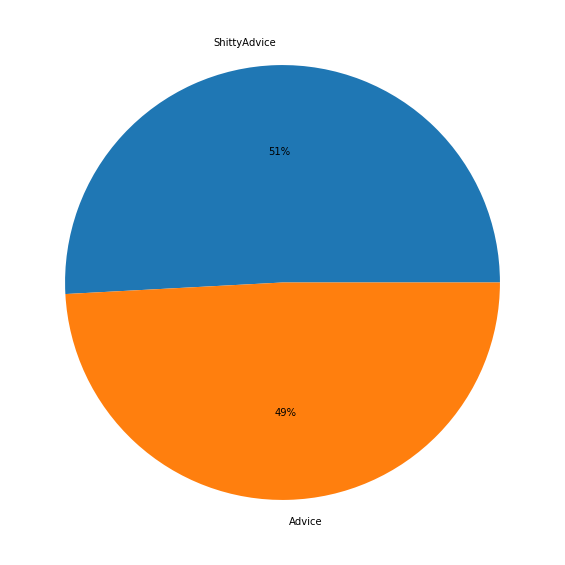

In [23]:
plt.figure(figsize=(25, 10))
labels=['ShittyAdvice', 'Advice']
plt.pie(y.value_counts(normalize=True), labels=labels,  autopct='%1.0f%%');

In [24]:
y.shape

(1949,)

We look at the distribution of lenght of titles to see how long are they on average and whether there is a skew.

In [25]:
len_status = [len(s) for s in X]

In [26]:
import matplotlib.pyplot as plt

(array([1675.,  187.,   54.,    9.,    9.,    3.,    3.,    4.,    3.,
           2.]),
 array([   15. ,  1343.5,  2672. ,  4000.5,  5329. ,  6657.5,  7986. ,
         9314.5, 10643. , 11971.5, 13300. ]),
 <a list of 10 Patch objects>)

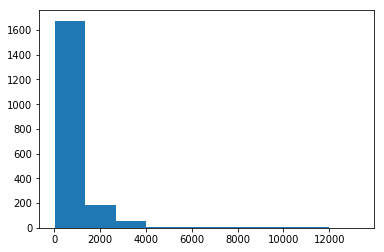

In [27]:
plt.hist(len_status)

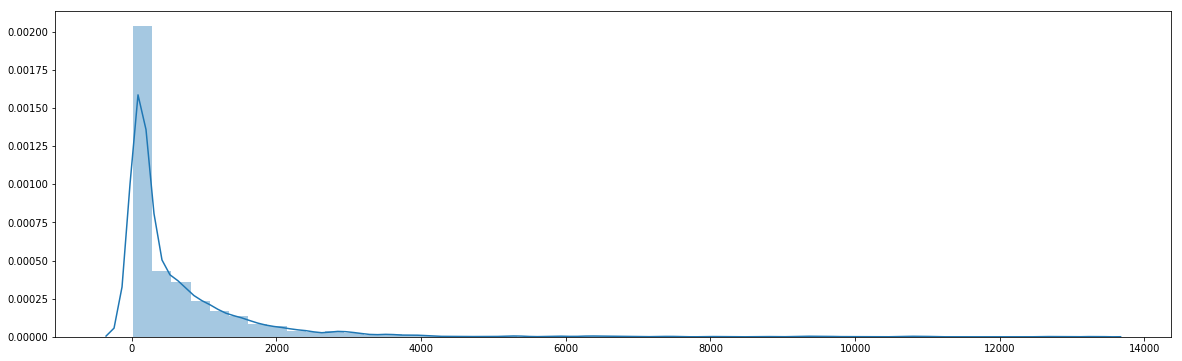

In [28]:
plt.figure(figsize=(20, 6))
sns.distplot(len_status)

(array([1.466e+03, 2.820e+02, 9.900e+01, 5.000e+01, 2.100e+01, 3.000e+00,
        6.000e+00, 5.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        3.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([3.00000e+00, 1.58020e+02, 3.13040e+02, 4.68060e+02, 6.23080e+02,
        7.78100e+02, 9.33120e+02, 1.08814e+03, 1.24316e+03, 1.39818e+03,
        1.55320e+03, 1.70822e+03, 1.86324e+03, 2.01826e+03, 2.17328e+03,
        2.32830e+03, 2.48332e+03, 2.63834e+03, 2.79336e+03, 2.94838e+03,
        3.10340e+03, 3.25842e+03, 3.41344e+03, 3.56846e+03, 3.72348e+03,
        3.8

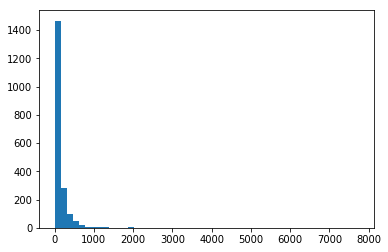

In [29]:
num_words= [len(s.split(' ')) for s in X]
plt.hist(num_words, bins=50)

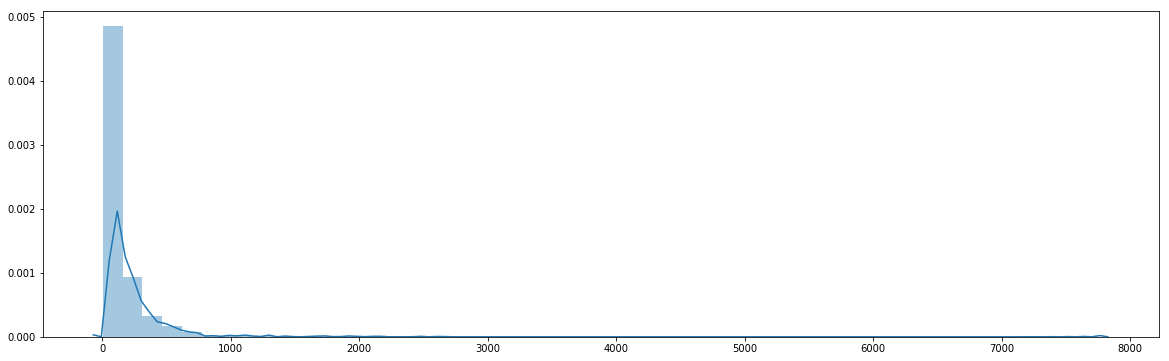

In [30]:
plt.figure(figsize=(20, 6))
sns.distplot(num_words)

There seems to be a bit of a right skew.
- In other words, some titles are very long.
    - The explanation for this is that some titles explain the whole situation, while others use the text to explain the situation.

# Cvec and Tvec Log vs Cvec and Tvec Bernoulli

In [31]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Base values (to check whether our models improve them)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [33]:
y_train.value_counts(normalize=True)

0    0.508812
1    0.491188
Name: subreddit type, dtype: float64

In [34]:
y_test.value_counts(normalize=True)

0    0.507764
1    0.492236
Name: subreddit type, dtype: float64

In [35]:
train_base = 0.490847
test_base = 0.491879

## Fitting Cvec

In [36]:
cvec = CountVectorizer(stop_words='english')

In [37]:
X_train_cvec = cvec.fit_transform(X_train)

In [38]:
X_test_cvec = cvec.transform(X_test)

In [39]:
y_test.value_counts(normalize=True) 

0    0.507764
1    0.492236
Name: subreddit type, dtype: float64

In [40]:
# Instantiate logistic regression.
lr = LogisticRegression()

# Fit logistic regression.
lr.fit(X_train_cvec, y_train)

# Evaluate logistic regression.
print(f'Training Score: {lr.score(X_train_cvec, y_train)}')
print(f'Testing Score: {lr.score(X_test_cvec, y_test)}')

Training Score: 0.9877394636015325
Testing Score: 0.8835403726708074


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [41]:
cvec_train_score = lr.score(X_train_cvec, y_train)

In [42]:
cvec_test_score  = lr.score(X_test_cvec, y_test)

This is the best score we got with our models. 

In [43]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [44]:
tokens = [w for w in X if not w in stop_words]

In [45]:
def get_top_n_words(corpus, n=None):

    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [46]:
aa = data['all_text'].loc[data['subreddit type']==1]

In [47]:
get_top_n_words(aa, n=50)

[('just', 1275),
 ('like', 1208),
 ('iâ', 1079),
 ('know', 928),
 ('want', 793),
 ('really', 765),
 ('time', 732),
 ('ve', 662),
 ('feel', 587),
 ('friends', 565),
 ('don', 561),
 ('school', 521),
 ('said', 493),
 ('donâ', 470),
 ('going', 450),
 ('friend', 439),
 ('told', 421),
 ('work', 412),
 ('help', 405),
 ('people', 401),
 ('think', 385),
 ('got', 379),
 ('things', 376),
 ('advice', 372),
 ('life', 356),
 ('job', 355),
 ('year', 348),
 ('need', 326),
 ('years', 322),
 ('make', 319),
 ('day', 319),
 ('lot', 308),
 ('way', 292),
 ('itâ', 292),
 ('good', 274),
 ('tell', 273),
 ('started', 264),
 ('talk', 259),
 ('did', 259),
 ('girl', 254),
 ('say', 251),
 ('ll', 243),
 ('parents', 241),
 ('family', 233),
 ('best', 224),
 ('went', 223),
 ('house', 221),
 ('getting', 218),
 ('love', 216),
 ('away', 216)]

In [48]:
bb = data['all_text'].loc[data['subreddit type']==0]

In [49]:
get_top_n_words(bb, n=50)

[('nan', 666),
 ('just', 127),
 ('want', 109),
 ('help', 86),
 ('like', 81),
 ('don', 76),
 ('really', 76),
 ('need', 75),
 ('iâ', 74),
 ('know', 73),
 ('best', 72),
 ('make', 71),
 ('way', 59),
 ('advice', 55),
 ('think', 54),
 ('ve', 54),
 ('wife', 54),
 ('time', 53),
 ('got', 50),
 ('people', 49),
 ('work', 47),
 ('day', 46),
 ('told', 44),
 ('good', 40),
 ('going', 38),
 ('stop', 38),
 ('girl', 37),
 ('money', 36),
 ('girlfriend', 36),
 ('tell', 34),
 ('new', 33),
 ('reddit', 33),
 ('getting', 32),
 ('does', 32),
 ('cat', 31),
 ('guy', 31),
 ('life', 31),
 ('friend', 28),
 ('year', 27),
 ('right', 27),
 ('said', 27),
 ('school', 27),
 ('sex', 26),
 ('says', 26),
 ('say', 26),
 ('old', 25),
 ('having', 25),
 ('shit', 25),
 ('sure', 25),
 ('things', 25)]

In [50]:
preds = lr.predict(X_test_cvec)

In [51]:
preds

array([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,

In [52]:
preds.mean()

0.4503105590062112

In [53]:
predictions = pd.DataFrame(index=X_test.index)

In [54]:
for i in range(10):
    
    # Instantiate decision trees.
    lr = LogisticRegression(random_state=42)
    
    # Fit to our training data.
    lr.fit(X_train_cvec, y_train)
    
    # Put predictions in dataframe.
    predictions[f'Tree {i}'] = lr.predict(X_test_cvec)

predictions

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,Tree 0,Tree 1,Tree 2,Tree 3,Tree 4,Tree 5,Tree 6,Tree 7,Tree 8,Tree 9
1064,1,1,1,1,1,1,1,1,1,1
1545,1,1,1,1,1,1,1,1,1,1
1724,0,0,0,0,0,0,0,0,0,0
1053,0,0,0,0,0,0,0,0,0,0
1821,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
255,1,1,1,1,1,1,1,1,1,1
536,0,0,0,0,0,0,0,0,0,0
1589,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0


In [55]:
predictions['probs'] = predictions.mean(axis='columns')

In [56]:
from sklearn.metrics import accuracy_score

In [57]:
accuracy_score(y_test, (predictions['probs']> 0.5).astype(int))

0.8835403726708074

In [58]:
# Import Pandas.
import pandas as pd

# Create DataFrame with column for predicted values.
results = pd.DataFrame(lr.predict(X_test_cvec), columns=['predicted'])

# Create column for observed values.
results['actual'] = y

In [59]:
results

,predicted,actual
0,1,0
1,1,0
2,0,1
3,0,1
4,0,0
...,...,...
639,1,0
640,0,1
641,0,0
642,0,1


In [60]:
y_test.head()

1064    1
1545    1
1724    1
1053    1
1821    0
Name: subreddit type, dtype: int64

In [61]:
from sklearn.metrics import precision_recall_fscore_support

y_true = y_test
y_pred = (predictions['probs']> 0.5)
precision_recall_fscore_support(y_true, y_pred, average=None)

(array([0.8559322 , 0.91724138]),
 array([0.9266055 , 0.83911672]),
 array([0.88986784, 0.87644152]),
 array([327, 317]))

In [62]:
from sklearn.model_selection import cross_val_score

lr = LogisticRegression()
print((cross_val_score(lr, X_test_cvec, y_test, cv=5)).mean())

0.8819230769230769


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Conclusions:
**The evaluation of the findings obtained in this jupyter notebook will be discussed in the .readme as well as in the presentation. The study presented here serves to collect the data which will later be evaluated in relation to the pertaining questions of the project.**